In [3]:
import numpy as np
import os
import torch as th
from skimage.measure import label, regionprops
from skimage.io import imread
from scipy.spatial import cKDTree
from torchvision import transforms
from collections import defaultdict
from nn.UNet import UNet 
from collagen_segment import segment_stack_given_stack
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd

In [15]:
def get_pore_properties(volume: np.ndarray):
    """Extracts centroids and areas of pores in each slice of a 3D volume."""
    slices = []
    for z, img in enumerate(volume):
        labeled_img = label(img)
        regions = regionprops(labeled_img)
        slices.append([(reg.centroid, reg.area) for reg in regions])  # Store (centroid, area)
    return slices

def track_and_compute_volumes(pore_slices, threshold=50.0, k=5, area_weight=0.5):
    """Tracks pores across slices based on centroid distance and area similarity."""
    pore_volumes = []
    tracked_pores = defaultdict(list)

    for z in range(len(pore_slices) - 1):
        if not pore_slices[z] or not pore_slices[z + 1]:
            continue

        # Extract centroids and areas
        centroids_z, areas_z = zip(*pore_slices[z]) if pore_slices[z] else ([], [])
        centroids_z1, areas_z1 = zip(*pore_slices[z + 1]) if pore_slices[z + 1] else ([], [])

        # Convert to numpy arrays
        centroids_z, centroids_z1 = np.array(centroids_z), np.array(centroids_z1)
        areas_z, areas_z1 = np.array(areas_z), np.array(areas_z1)

        # Handle edge cases where there are no centroids
        if centroids_z.shape[0] == 0 or centroids_z1.shape[0] == 0:
            continue

        # Build KD-Tree for nearest neighbors search
        tree = cKDTree(centroids_z1)

        # Ensure query always returns an array
        k_neighbors = min(k, len(centroids_z1))  # Don't request more neighbors than available
        distances, indices = tree.query(centroids_z, k=k_neighbors)

        # If only one pore is present, ensure it’s iterable
        if distances.ndim == 1:
            distances = distances[:, np.newaxis]
            indices = indices[:, np.newaxis]

        # Match pores based on both distance and area similarity
        for i in range(len(centroids_z)):  
            best_idx = None
            best_score = float("inf")

            for d, idx in zip(distances[i], indices[i]):
                if d >= threshold:
                    continue
                
                area_diff = abs(areas_z[i] - areas_z1[idx]) / (areas_z[i] + areas_z1[idx] + 1e-6)  # Normalize
                score = d + area_weight * area_diff  # Combined metric

                if score < best_score:
                    best_score = score
                    best_idx = idx

            if best_idx is not None:
                tracked_pores[best_idx].append(areas_z[i])

    # Compute volumes
    for tracked in tracked_pores.values():
        pore_volumes.append(sum(tracked))  

    return pore_volumes


def interpolate_stack(stack, num_interpolations=10):
    """Interpolates between slices to create a denser stack."""
    interpolated_stack = [] 
    for i in range(len(stack) - 1):
        interpolated_stack.append(stack[i])
        interpolated_images = np.linspace(stack[i], stack[i+1], num=num_interpolations+2)[1:-1]
        interpolated_stack.extend(interpolated_images)  # Add interpolated images to the stack
    interpolated_stack.append(stack[-1])  # End with the last image
    return np.array(interpolated_stack)

In [12]:
# Load metadata
metadata_file = "/mnt/d/d_merged12/dataset.csv"
with open(metadata_file, 'r') as f:
    files, conditions = [], []
    for line in f:
        file, cond = line.strip().split(',')
        files.append(file)
        conditions.append(cond)

dataset_path = "/mnt/d/d_merged12/dataset/"
device = th.device("cuda:0" if th.cuda.is_available() else "cpu")
model = UNet(1, 1).to(device)
model.load_state_dict(th.load("/home/quantum/MScThesisCode/unet.th", weights_only=True))
model = model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

In [20]:
d_3d = {}
for cond in conditions:
    d_3d[cond] = []

i = 1
for file, cond in zip(files, conditions):
    print(f"Processing {i}/{len(files)}: {file}")

    # Read stack and interpolate
    original_stack = np.asarray(imread(os.path.join(dataset_path, file)), dtype=np.float32)
    interpolated_stack = interpolate_stack(original_stack, num_interpolations=10)

    # Segment stack
    segmented_stack = segment_stack_given_stack(model, interpolated_stack, transform, device)

    # Extract pore properties
    pore_slices = get_pore_properties(segmented_stack)

    # Compute pore volumes
    pore_volumes = track_and_compute_volumes(pore_slices, threshold=50.0, area_weight=.8)

    # Store results
    d_3d[cond].extend(pore_volumes)
    i += 1

Processing 1/22: 15_D6.tif
Processing 2/22: 27_E6.tif
Processing 3/22: 16_D7.tif
Processing 4/22: 28_E7.tif
Processing 5/22: 64_K3.tif
Processing 6/22: 65_K4.tif
Processing 7/22: 17_D8.tif
Processing 8/22: 29_E8.tif
Processing 9/22: 61_I4.tif
Processing 10/22: 62_J3.tif
Processing 11/22: 63_J4.tif
Processing 12/22: 11_D5.tif
Processing 13/22: 18_E5.tif
Processing 14/22: 25_F5.tif
Processing 15/22: 02_C4.tif
Processing 16/22: 10_D4.tif
Processing 17/22: 17_E4.tif
Processing 18/22: 24_F4.tif
Processing 19/22: 06_C8.tif
Processing 20/22: 01_C3.tif
Processing 21/22: 09_D3.tif
Processing 22/22: 16_E3.tif


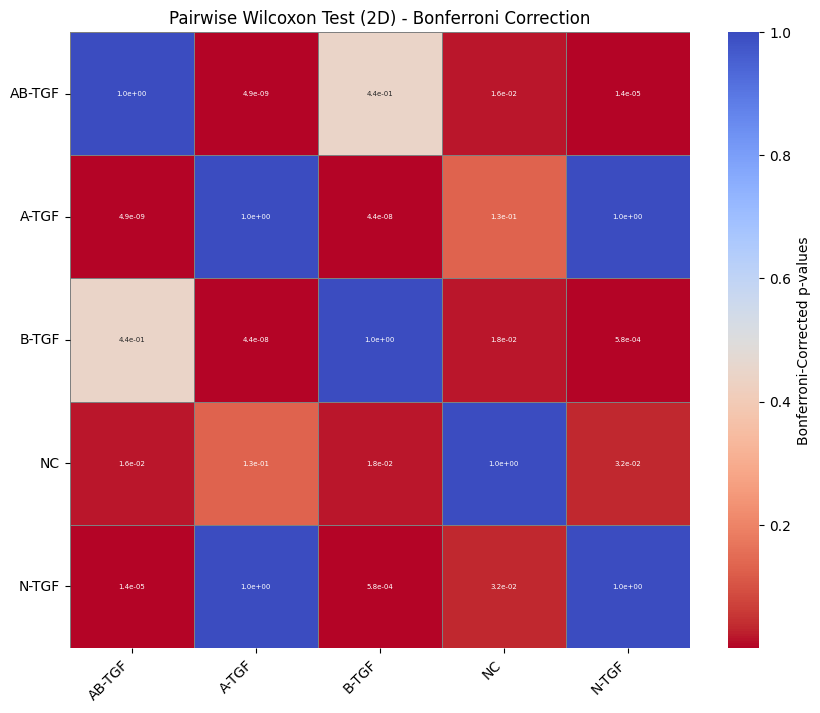

In [21]:
import pandas as pd
from scipy.stats import mannwhitneyu
from itertools import combinations
import numpy as np

# Function to compute pairwise Wilcoxon tests with Bonferroni correction
def pairwise_wilcoxon_bonferroni(df):
    categories = df['Category'].unique()
    p_values = pd.DataFrame(index=categories, columns=categories, dtype=float)
    n_comparisons = len(list(combinations(categories, 2)))  # Total number of pairwise comparisons

    raw_p_values = []  # Store raw p-values before correction

    for cat1, cat2 in combinations(categories, 2):
        group1 = df[df['Category'] == cat1]['Volume']
        group2 = df[df['Category'] == cat2]['Volume']
        stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
        raw_p_values.append((cat1, cat2, p))

    # Apply Bonferroni correction
    for cat1, cat2, p in raw_p_values:
        corrected_p = min(p * n_comparisons, 1)  # Adjust p-value and cap at 1
        p_values.loc[cat1, cat2] = corrected_p
        p_values.loc[cat2, cat1] = corrected_p  # Fill symmetric value

    np.fill_diagonal(p_values.values, 1)  # Set diagonal to 1 (self-comparison)
    return p_values

# Compute pairwise Wilcoxon test with Bonferroni correction for both 2D and 3D datasets
df_3d = pd.DataFrame([(cat, vol) for cat, vols in d_3d.items() for vol in vols], 
                  columns=["Category", "Volume"])
p_values_3d_bonferroni = pairwise_wilcoxon_bonferroni(df_3d)

def plot_heatmap(p_values, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        p_values.astype(float),  # Ensure values are float for color mapping
        annot=True,  # Show p-values
        fmt=".1e",  # Scientific notation for small p-values
        cmap="coolwarm_r",  # Use a diverging colormap (red-blue)
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={'label': 'Bonferroni-Corrected p-values'},
        annot_kws={"size": 5}
    )
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.yticks(rotation=0)
    plt.show()

plot_heatmap(p_values_3d_bonferroni, "Pairwise Wilcoxon Test (2D) - Bonferroni Correction")